# MegaMart Customer Segmentation Analysis
### TEAM 10
- Luis Alan Morales Castillo A01659147
-  Paulina Díaz Arroyo A01029592
- Rodrigo Jiménez Ortiz A01029623

## Section 1: Project Setup & Data Loading

In [274]:
import pandas as pd
import numpy as np
from sklearn import datasets
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

In [275]:
df = pd.read_csv("retail_customer_data-1.csv")  
df.head()

,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [276]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


#### Initial Findings

The dataset contains 3,000 records of active customers. There are no null values in any variable, indicating that the dataset is complete and clean.

Out of the 10 columns, 9 are numerical behavioral variables and 1 is an identifier (`customer_id`). The key behavioral metrics include: `monthly_transactions`, `avg_basket_size`, `total_spend`, `avg_session_duration`, `email_open_rate`, `product_views_per_visit`, `return_rate`, `customer_tenure_months`, and `recency_days`.

There is high variability in customer behavior. For instance, total annual spending (`total_spend`) ranges from as low as $50 to over $8,700; email open rates (`email_open_rate`) vary from 0.00 to 0.95; and customer tenure (`customer_tenure_months`) spans from 1 to 59 months. Additionally, the data shows significant differences in scale between variables ( `return_rate` ranges from 0.00 to 0.50, while `total_spend` reaches up to 8,700).

## Section 2: Exploratory Data Analysis (EDA)

### 2.1-Variable Distributions:

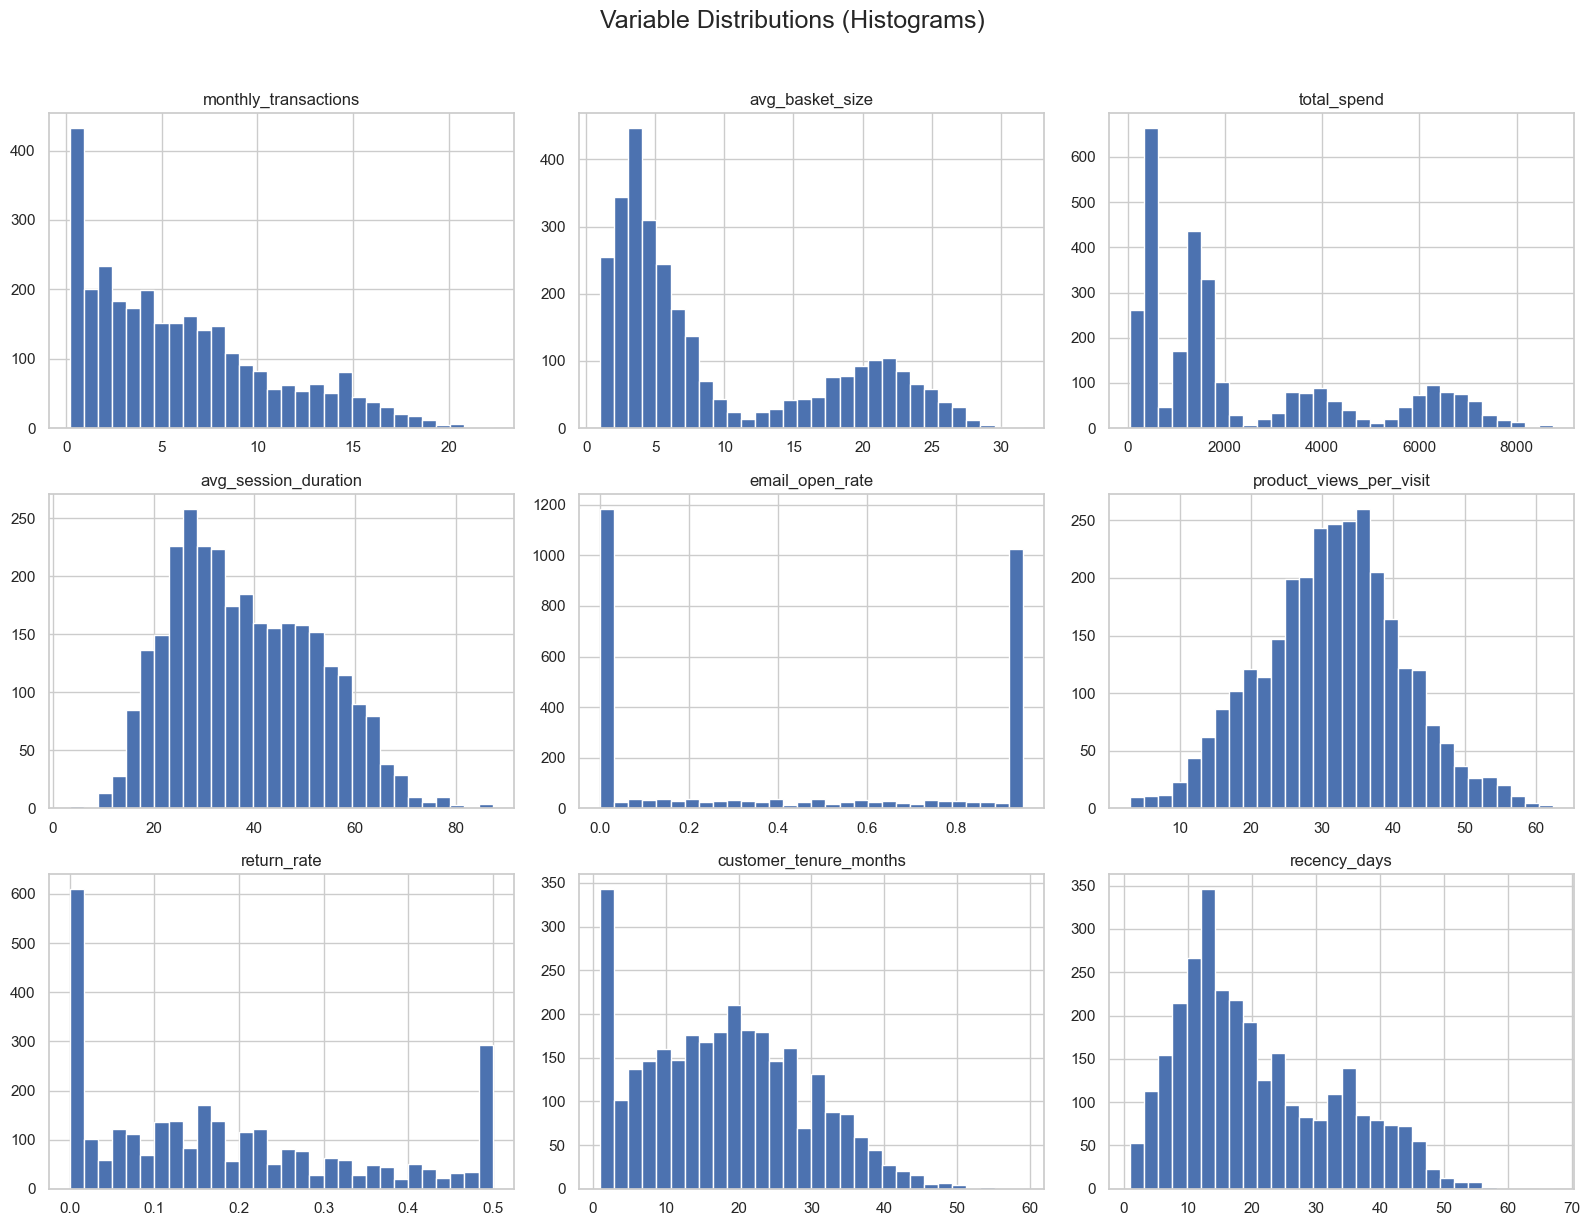

In [277]:
df_numeric = df.drop(columns=["customer_id"])
sns.set(style="whitegrid")
df_numeric.hist(bins=30, figsize=(16, 12), layout=(3, 3))
plt.suptitle("Variable Distributions (Histograms)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


### 2.2-Correlation Analysis

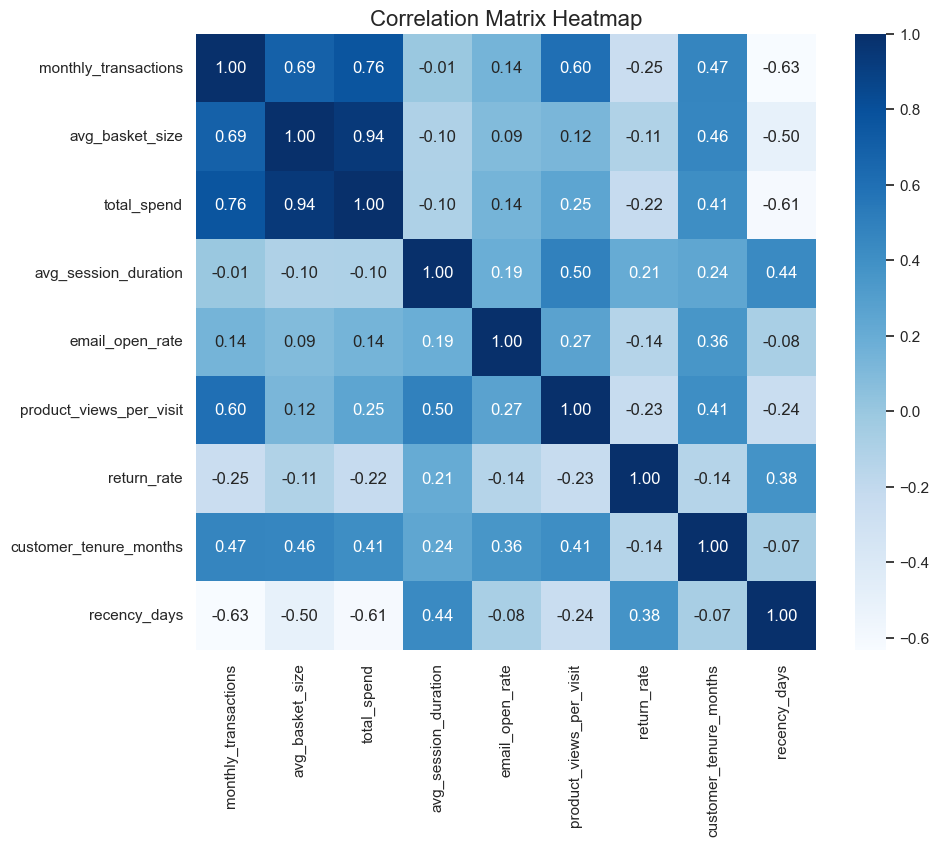

In [278]:
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()


### Highly correlated variables

The correlation matrix reveals several strong relationships between  variables:

- **`avg_basket_size` and `total_spend`** show a very strong positive correlation (**0.94**), suggesting that customers who spend more typically have larger baskets.
- **`monthly_transactions` and `total_spend`** are also highly correlated (**0.76**), indicating that more frequent shoppers tend to spend more overall.
- **`monthly_transactions` and `avg_basket_size`** have a moderate positive correlation (**0.69**), which reinforces the pattern of more active customers also having higher basket values.
- **`avg_session_duration` and `product_views_per_visit`** are moderately correlated (**0.50**), hinting that longer sessions lead to more product exploration.
- **`recency_days`** is **negatively correlated** with both `monthly_transactions` (**-0.63**) and `total_spend` (**-0.61**), suggesting that more recent activity is associated with higher engagement and spending.



### 2.3-Outlier Detection:

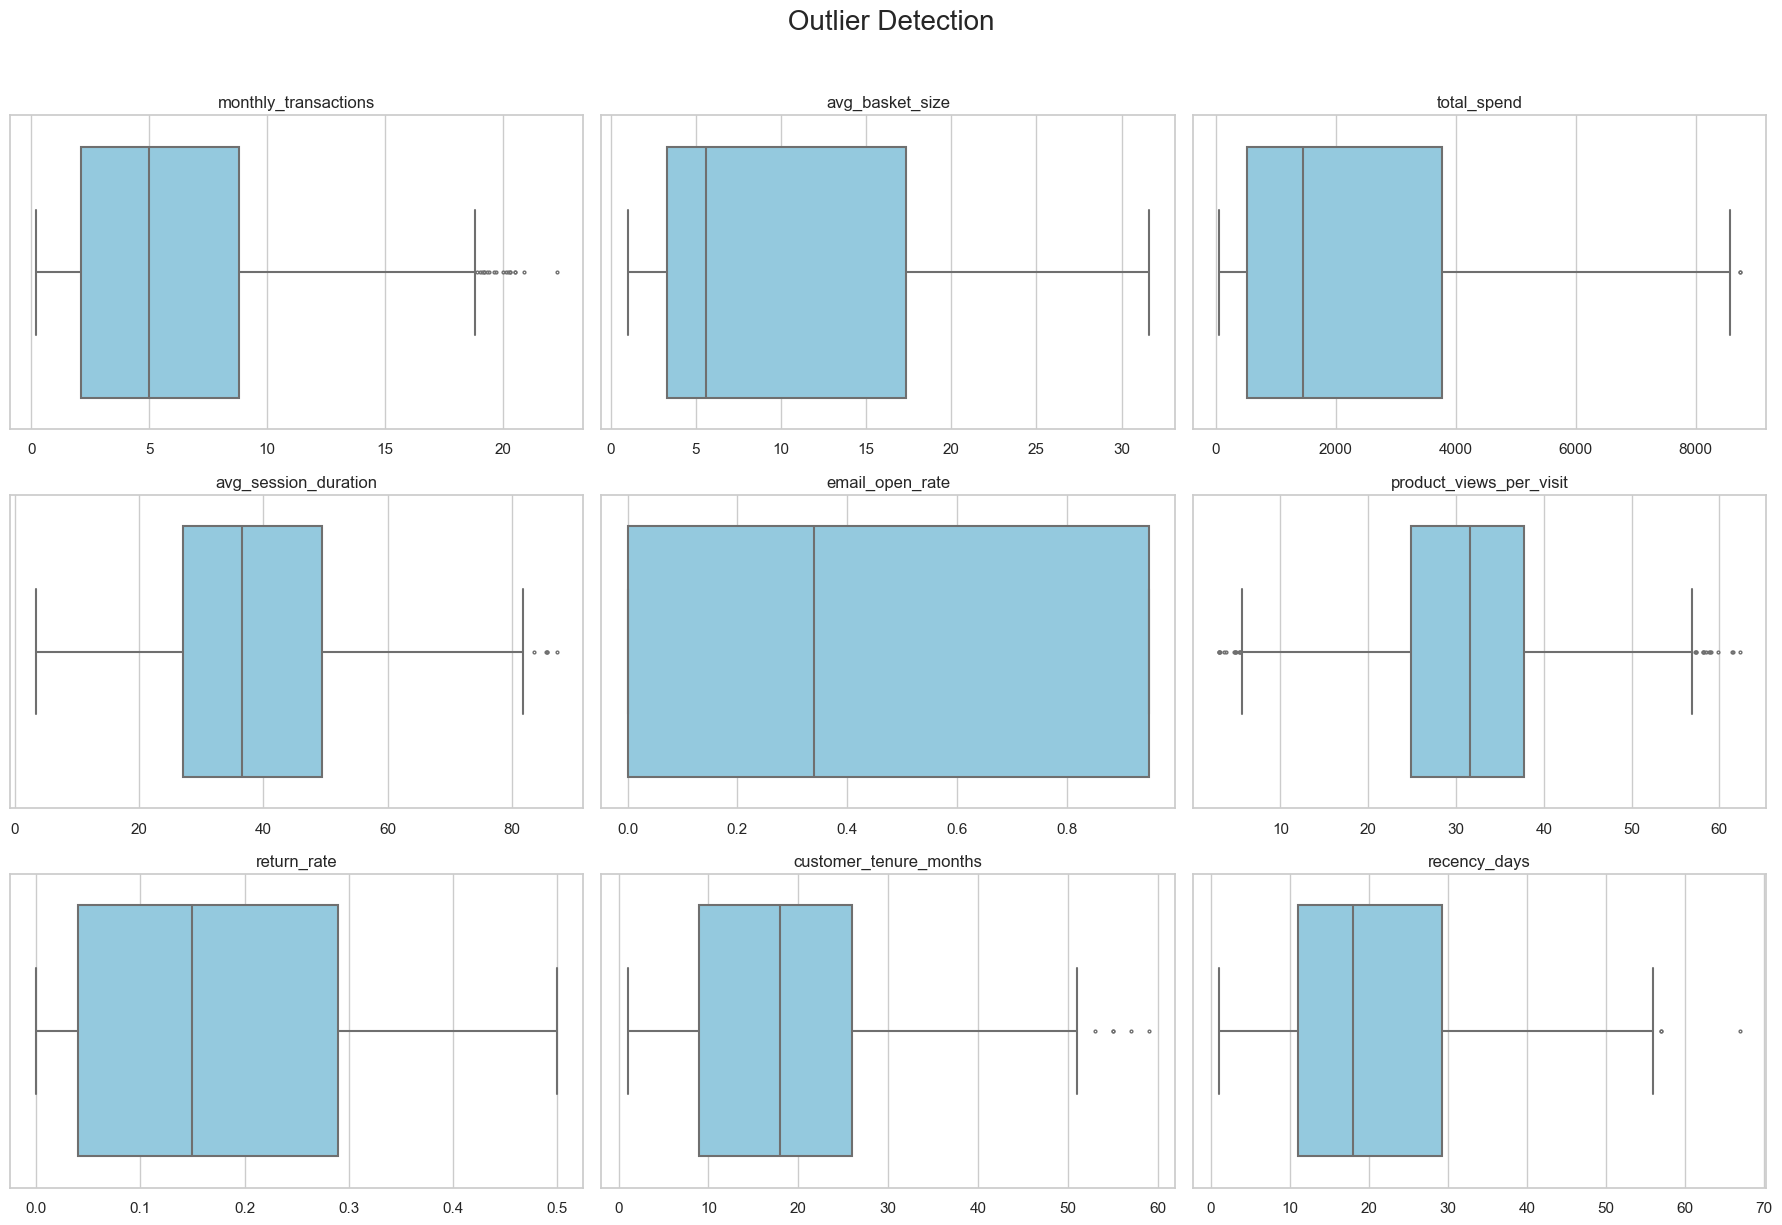

In [279]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle(" Outlier Detection ", fontsize=20, y=1.02)

for ax, col in zip(axes.flatten(), df_numeric.columns):
    sns.boxplot(x=df_numeric[col], 
                ax=ax, 
                color="skyblue", 
                fliersize=2, 
                linewidth=1.5)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("")
    
plt.tight_layout()
plt.show()

### 2.4-Scatter Plots:

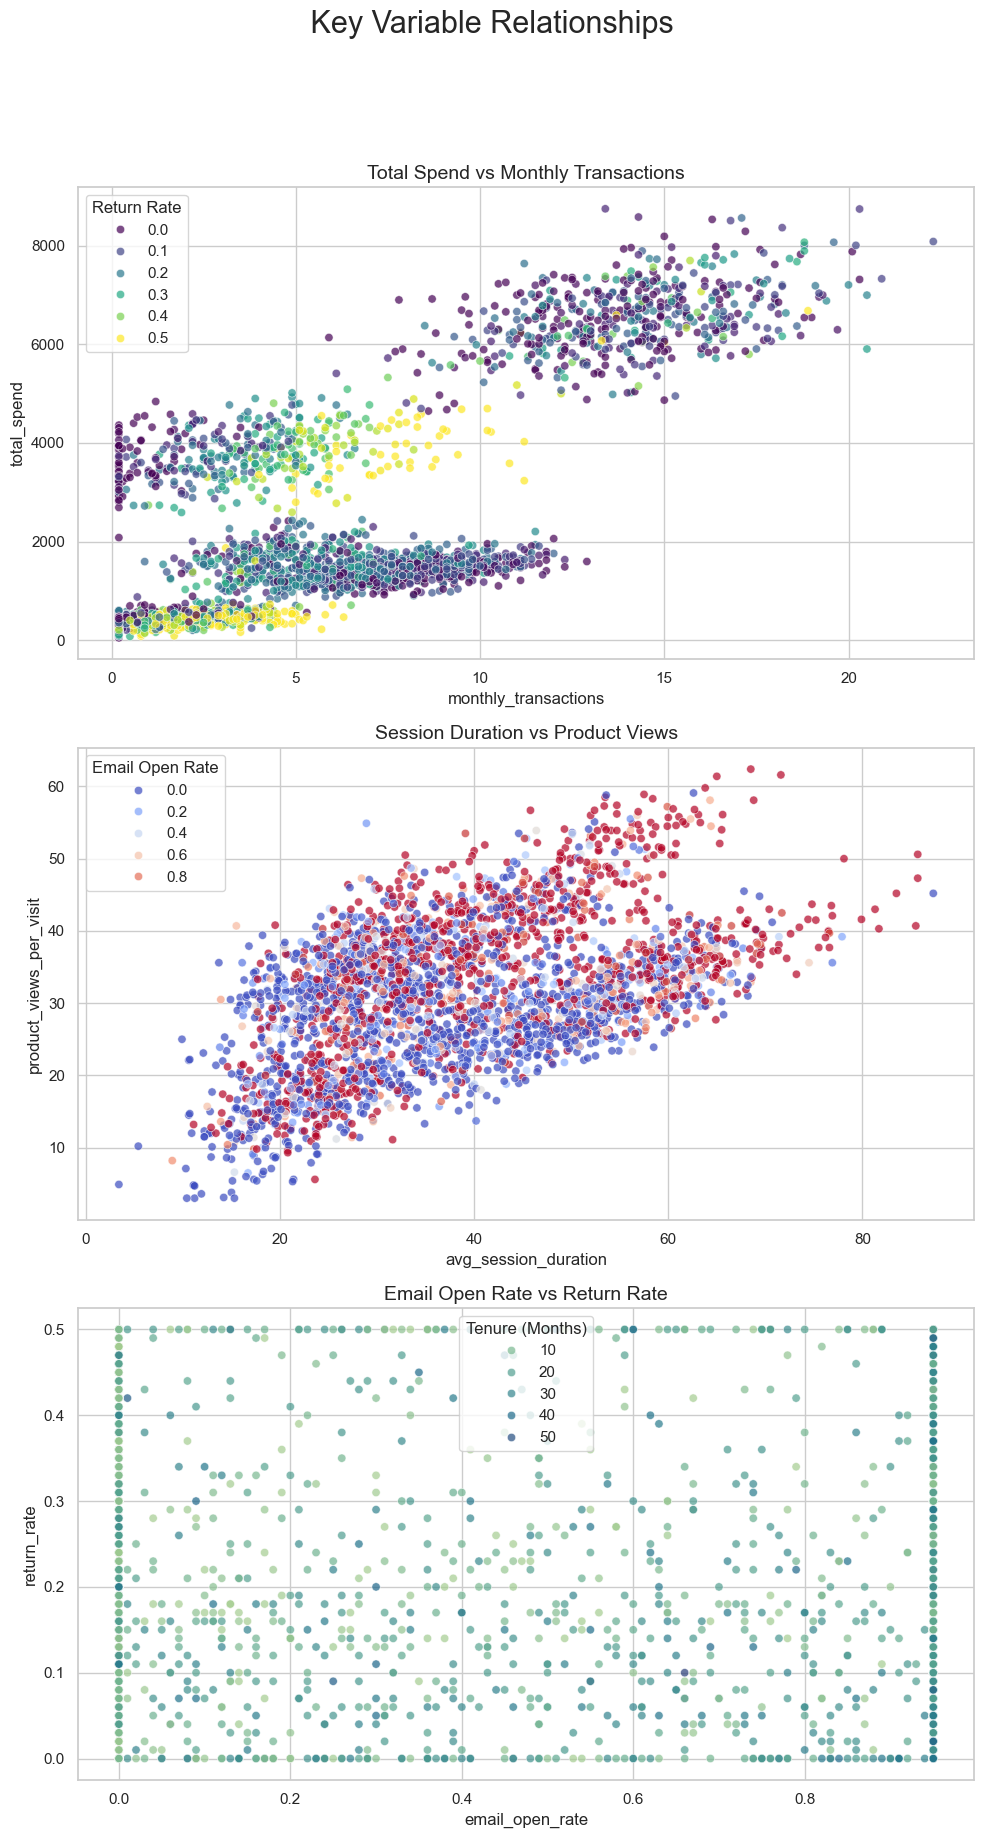

In [280]:
sns.set(style="whitegrid")
df_numeric = df.drop(columns=["customer_id"])

fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle(" Key Variable Relationships ", fontsize=22, y=1.02)

sns.scatterplot(data=df_numeric,
                x="monthly_transactions", y="total_spend",
                hue="return_rate", palette="viridis", alpha=0.7,
                ax=axes[0])
axes[0].set_title("Total Spend vs Monthly Transactions", fontsize=14)
axes[0].legend(title="Return Rate", loc="best")

sns.scatterplot(data=df_numeric,
                x="avg_session_duration", y="product_views_per_visit",
                hue="email_open_rate", palette="coolwarm", alpha=0.7,
                ax=axes[1])
axes[1].set_title("Session Duration vs Product Views", fontsize=14)
axes[1].legend(title="Email Open Rate", loc="best")

sns.scatterplot(data=df_numeric,
                x="email_open_rate", y="return_rate",
                hue="customer_tenure_months", palette="crest", alpha=0.7,
                ax=axes[2])
axes[2].set_title("Email Open Rate vs Return Rate", fontsize=14)
axes[2].legend(title="Tenure (Months)", loc="best")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()




## Section 3: Data Preprocessing

### 3.1-Check for Missing Data:

In [281]:
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print(" No missing values.")


 No missing values.


### 3.2-Standardization

In [282]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled_array, columns=df_numeric.columns)
df_scaled.head()



,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,-0.881806,-0.814720,-0.818692,-0.023831,1.184799,-1.411249,-1.145657,0.452593,1.022062
1,-0.128000,-0.626277,-0.547025,-1.286759,-1.038395,-1.531702,1.381211,-1.504629,-1.052040
2,-0.651476,-0.638840,-0.754970,1.804276,0.178511,0.556143,-0.467717,1.253275,1.519847
3,1.253976,1.672732,1.775871,-0.037786,-0.640561,1.088142,-1.145657,0.274664,-1.300932
4,-0.798050,1.019462,0.752305,-1.112321,0.201913,-1.300834,-0.221193,0.185699,-0.222399


In [283]:
df_scaled.describe()



,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,1.290819e-16,-4.263256e-17,2.842171e-17,7.460699e-17,-8.526513e-17,4.973799e-17,-1.539509e-16,2.368476e-18,-4.263256e-17
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-1.216830e+00,-1.065978e+00,-1.030908e+00,-2.445025e+00,-1.038395e+00,-2.846642e+00,-1.145657e+00,-1.504629e+00,-1.632788e+00
25%,-8.189887e-01,-7.770313e-01,-8.257765e-01,-7.983336e-01,-1.038395e+00,-6.483828e-01,-8.991336e-01,-7.929123e-01,-8.031475e-01
50%,-2.117565e-01,-4.880849e-01,-4.053880e-01,-1.319818e-01,-2.427260e-01,2.414405e-02,-2.211934e-01,7.769579e-03,-2.223990e-01
75%,5.839270e-01,9.849136e-01,6.249629e-01,7.646276e-01,1.184799e+00,6.464824e-01,6.416396e-01,7.194868e-01,7.109468e-01
max,3.410697e+00,2.778266e+00,2.837726e+00,3.409102e+00,1.184799e+00,3.115760e+00,1.935889e+00,3.655320e+00,3.842841e+00


### 3.3-Explain your choice

###  Standardization in Clustering

Standardization is essential before applying clustering algorithms because most clustering methods  rely on distance based calculations. Without standardizing, variables with larger numerical ranges would disproportionately influence the results. In the original dataset, the `total_spend` variable ranges from **$50 to over $8,700**, while `return_rate` ranges only from **0.00 to 0.50**. If we don’t scale the data, `total_spend` will dominate the distance metric simply due to its magnitude, even if `return_rate` is more informative.Whit standardization  we bring all variables to a common scale, ensuring that each variable contributes equally to the clustering.

You can clearly see the difference by comparing the `.describe()` output of both DataFrames:
- Before standardization, variables had different means and wildly varying ranges.
- After standardization, all variables have similar ranges (mostly between -2 and +3) and standard deviations around 1.




## Section 4: Hierarchical Clustering Analysis

### 4.1-Compute Linkage Matrices

In [284]:
linkage_single = linkage(df_scaled, method='single')
linkage_complete = linkage(df_scaled, method='complete')
linkage_average = linkage(df_scaled, method='average')
linkage_ward = linkage(df_scaled, method='ward')

### 4.2-Create Dendrograms

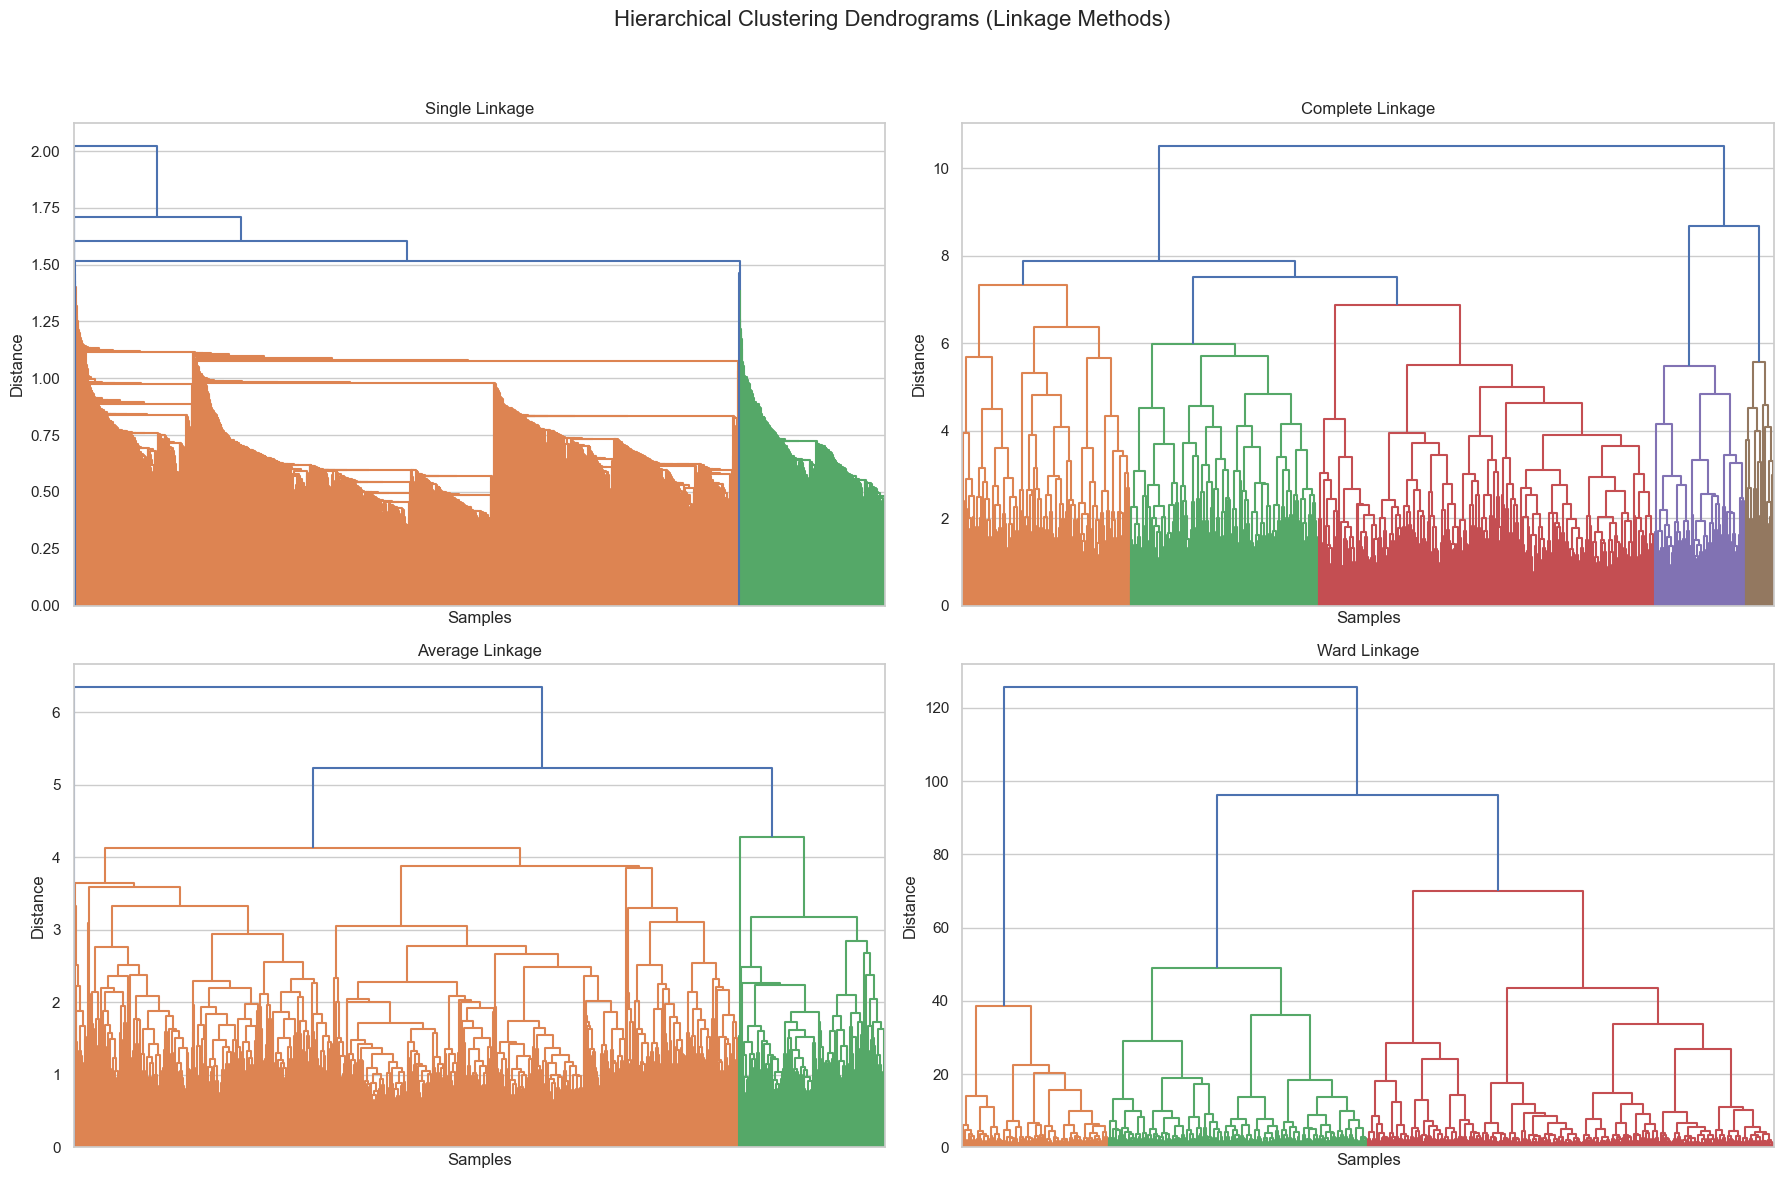

In [285]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Hierarchical Clustering Dendrograms (Linkage Methods)', fontsize=16)
dendrogram(linkage_single, ax=axes[0, 0], no_labels=True)
axes[0, 0].set_title("Single Linkage")
dendrogram(linkage_complete, ax=axes[0, 1], no_labels=True)
axes[0, 1].set_title("Complete Linkage")
dendrogram(linkage_average, ax=axes[1, 0], no_labels=True)
axes[1, 0].set_title("Average Linkage")
dendrogram(linkage_ward, ax=axes[1, 1], no_labels=True)
axes[1, 1].set_title("Ward Linkage")
for ax in axes.flat:
    ax.set_xlabel("Samples")
    ax.set_ylabel("Distance")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 4.3-Interpret Dendrograms

##### How do the linkage methods work?
- Single Linkage: Merges clusters based on the minimum distance between any pair of points from each group. 

- Complete Linkage: Uses the maximum distance between points from different groups. 

- Average Linkage: Calculates the average distance between all pairs of points across clusters. 

- Ward Linkage: Merges clusters that result in the smallest increase in total variance within groups.


##### Which linkage method appears most suitable? 
The Ward method seems to be the best for grouping customers.It works by keeping the groups as similar as possible internally.
In its dendrogram, we can see large vertical gaps, which means the clusters are well separated.

##### Where would you cut the dendrogram? What does the height of merges tell you?
In dendrograms, the height of the lines where clusters merge shows how different the groups are.
The taller the line, the more different the groups were before merging. In the Ward method, there is a big merge at around height 100–120, so it would be a good idea to cut around height 80-100.This would give us 3 well separated clusters.

##### What is the "chaining effect" and which linkage method is most susceptible to it?
The chaining effect happens when points are merged one by one, creating a long chain instead of clear groups. This mostly affects the Single Linkage method, which merges based on the closest point between groups.In the Single Linkage dendrogram, merges are low and continuous, with no clear cluster boundaries.

#### What do we see in the dendrograms?
- Single Linkage: Many small clusters merge progressively. The chaining effect is visible.

- Complete Linkage: Merging is more controlled, but some groups are still not very compact.

- Average Linkage: Results are more balanced, though not as clearly defined as in Ward.

- Ward Linkage: Clearly shows large separations between clusters. Ideal for cutting into 3 clusters.

## Section 5: Determining Optimal Number of Clusters (Hierarchical)

### 5.1-Focused Dendrogram

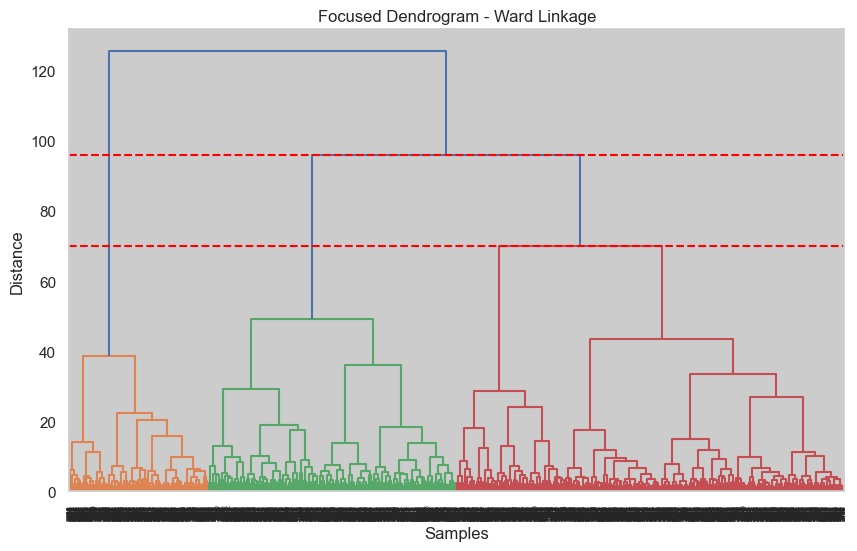

In [286]:
plt.figure(figsize=(10, 6))
dendrogram(linkage_ward)
plt.axhline(y=96, color='red', linestyle='--')  
plt.axhline(y=70, color='red', linestyle='--')  
plt.title('Focused Dendrogram - Ward Linkage')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


### 5.2-Extract Clusters

In [287]:
cluster_labels = {}
for k in [3, 4, 5, 6]:
    cluster_labels[k] = fcluster(linkage_ward, k, criterion='maxclust')

### 5.3-Calculate Silhouette Scores

In [288]:
silhouette_scores = {}
for k in [3, 4, 5, 6]:
    score = silhouette_score(df_scaled, cluster_labels[k])
    silhouette_scores[k] = score

### 5.4-Create a Table

   k  Silhouette Score
0  3          0.294781
1  4          0.315700
2  5          0.300267
3  6          0.247512


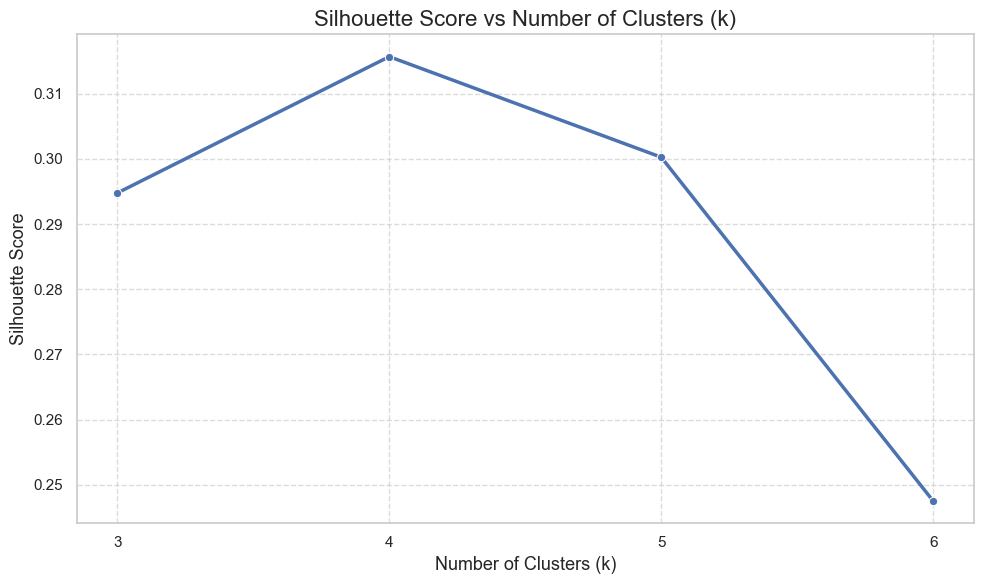

In [289]:
silhouette_df = pd.DataFrame({
    'k': list(silhouette_scores.keys()),
    'Silhouette Score': list(silhouette_scores.values())
})
print(silhouette_df)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=silhouette_df, x='k', y='Silhouette Score', marker='o', linewidth=2.5)
plt.title('Silhouette Score vs Number of Clusters (k)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.xticks(silhouette_df['k'])  # Asegura que los ticks estén en los valores de k
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Section 6: K-Means Clustering - Elbow Method

### 6.1-Inertia Calculation:

In [290]:
inertias = []
silhouette_scores = []
K = range(2, 11) 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

### 6.2-Elbow Plot

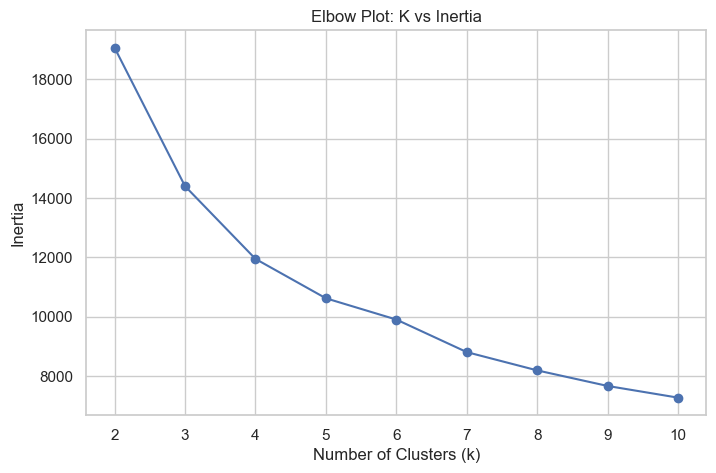

In [291]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Plot: K vs Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### 6.3-Silhouette Scores

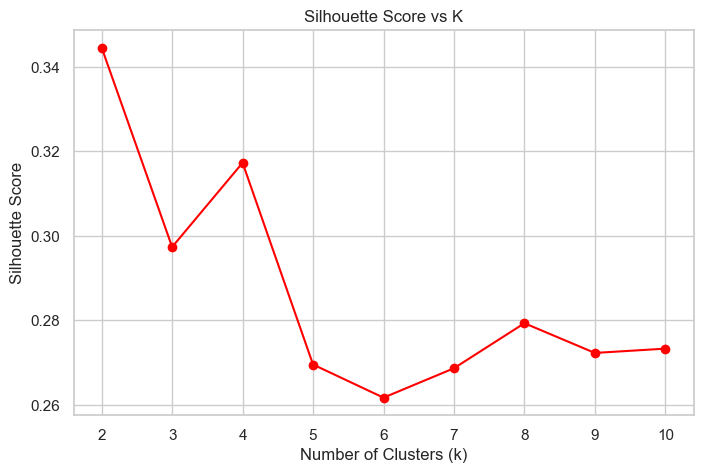

In [292]:
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### 6.4-Dual Plot

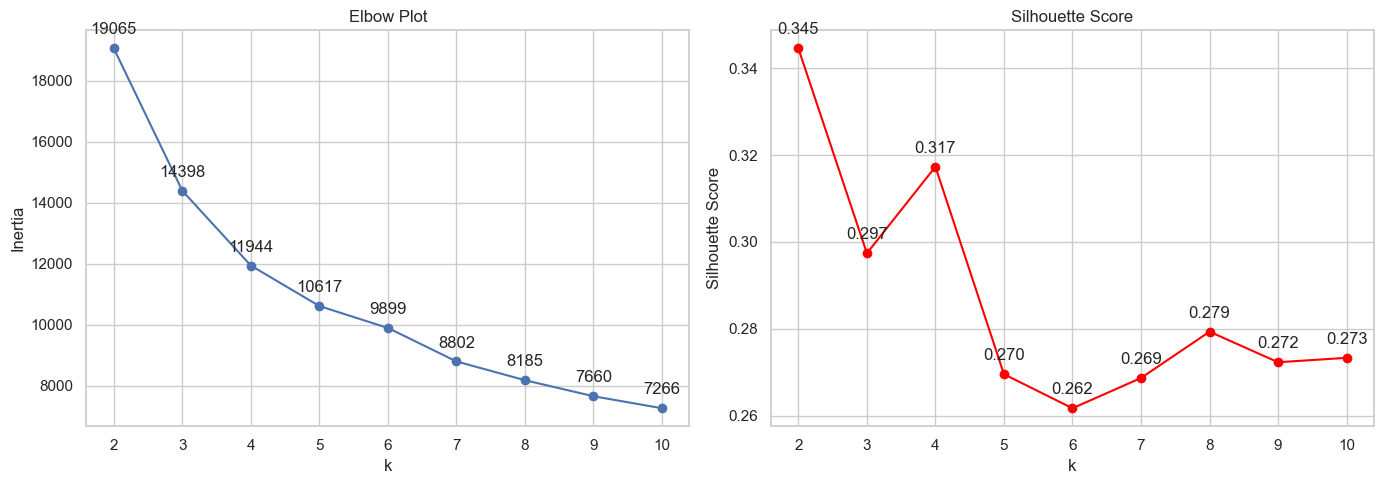

In [293]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(K, inertias, marker='o')
axs[0].set_title('Elbow Plot')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

for i, (k, inertia) in enumerate(zip(K, inertias)):
    axs[0].annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", xytext=(0,10), ha='center')


axs[1].plot(K, silhouette_scores, marker='o', color='red')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

for i, (k, score) in enumerate(zip(K, silhouette_scores)):
    axs[1].annotate(f'{score:.3f}', (k, score), textcoords="offset points", xytext=(0,10), ha='center')
    
plt.tight_layout()
plt.show()



### 6.5-Interpretation


The **Elbow Plot** shows the inertia  decreasing as k increases. The most significant drop happens between k = 2 and k = 4. After k = 4, the curve starts to flatten, indicating that adding more clusters doesn’t reduce inertia as much.
- k = 2 → ~19065  
- k = 3 → ~14398  
- k = 4 → ~11944 
------------------
- k = 5 → ~10617  
- k = 6 → ~9899  
- k = 7 → ~8802

The elbow is observed at k = 4.

The **Silhouette Score** helps assess how well defined the clusters are:
- k = 2 has the highest silhouette score (~0.345).
- k = 4 has the second highest score (~0.317), showing strong cluster separation.
- Scores decline after k=4, suggesting worse cluster definition.

Based on the Elbow and Silhouette Score analyses, **k = 4** is chosen as the optimal number of clusters. It represents the elbow point where inertia significantly levels off, and it also shows a high silhouette score (0.317), indicating well separated and cohesive clusters. 


## Section 7: Final Cluster Selection

### 7.1-Choose Optimal k

Based on both hierarchical clustering and K-means analysis, we will test both **k = 3** and **k = 4** as potential optimal values for the number of clusters.

### 7.2-Justify Your Choice

- **Elbow Plot**: The elbow point is clearly visible at **k = 4**, where the inertia starts to decrease more slowly. This indicates a good trade-off between model complexity and explained variance.

- **Silhouette Scores**: While **k = 2** had the highest silhouette score, **k = 4** also showed a strong score (0.317), second only to k = 2, and it provides more refined clustering. **k = 3** had a slightly lower silhouette score (0.297), but it is still competitive and offers simpler segmentation.

- **Hierarchical Dendrogram**: The dendrogram shows the largest vertical separation between clusters when cut at around **3 or 4 clusters**, indicating natural grouping in the data.

Based on the elbow point, silhouette scores, and the hierarchical dendrogram structure, both **k = 3** and **k = 4** are strong candidates. We will proceed with further analysis using both values to evaluate their interpretability and usefulness for actionable insights.

## Section 8: Apply Final K-Means Model

### 8.1-Fit K-Means

In [294]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(df_scaled)


kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(df_scaled)

KMeans(n_clusters=4, random_state=42)

### 8.2- Extract Cluster Labels


In [295]:
labels_3 = kmeans_3.labels_
labels_4 = kmeans_4.labels_

### 8.3-Cluster Sizes

In [296]:
df_3 = pd.DataFrame({'Cluster': labels_3})
sizes_3 = df_3['Cluster'].value_counts().sort_index()
percent_3 = (sizes_3 / len(df_3)) * 100

summary_3 = pd.DataFrame({
    'Cluster': sizes_3.index,
    'Count (k=3)': sizes_3.values,
    'Percentage (k=3)': percent_3.round(2).values
})


df_4 = pd.DataFrame({'Cluster': labels_4})
sizes_4 = df_4['Cluster'].value_counts().sort_index()
percent_4 = (sizes_4 / len(df_4)) * 100

summary_4 = pd.DataFrame({
    'Cluster': sizes_4.index,
    'Count (k=4)': sizes_4.values,
    'Percentage (k=4)': percent_4.round(2).values
})

print("Cluster Sizes for k = 3:")
print(summary_3)

print("\nCluster Sizes for k = 4:")
print(summary_4)


Cluster Sizes for k = 3:
   Cluster  Count (k=3)  Percentage (k=3)
0        0         1526             50.87
1        1          944             31.47
2        2          530             17.67

Cluster Sizes for k = 4:
   Cluster  Count (k=4)  Percentage (k=4)
0        0          525             17.50
1        1          929             30.97
2        2          433             14.43
3        3         1113             37.10


## Section 9: Cluster Profiling and Interpretation

### 9.1-Add Clusters to Original Data

In [297]:
df_numeric['cluster_3'] = kmeans_3.labels_
df_numeric['cluster_4'] = kmeans_4.labels_

### 9.2-Calculate Cluster Means

In [298]:
cluster_means_3 = df_numeric.groupby('cluster_3').mean(numeric_only=True)
cluster_means_4 = df_numeric.groupby('cluster_4').mean(numeric_only=True)


In [299]:
print(cluster_means_3 )


           monthly_transactions  avg_basket_size  total_spend  \
cluster_3                                                       
0                      5.911599         9.109567  2139.184417   
1                      1.664725         3.031038   422.150689   
2                     14.040189        22.062075  6489.095264   

           avg_session_duration  email_open_rate  product_views_per_visit  \
cluster_3                                                                   
0                     27.411206         0.440229                28.227851   
1                     52.139301         0.375593                29.971081   
2                     45.803019         0.575113                42.849057   

           return_rate  customer_tenure_months  recency_days  cluster_4  
cluster_3                                                                
0             0.162235               16.671035     15.952818   2.718218  
1             0.270953               15.180085     35.367585   1.0

In [300]:
print(cluster_means_4 )

           monthly_transactions  avg_basket_size  total_spend  \
cluster_4                                                       
0                     14.073524        22.025714  6507.290648   
1                      1.683100         3.050161   422.620377   
2                      4.042494        18.173903  3875.935543   
3                      6.586972         5.560647  1450.947125   

           avg_session_duration  email_open_rate  product_views_per_visit  \
cluster_4                                                                   
0                     45.918095         0.576210                43.008571   
1                     52.308719         0.374166                30.014532   
2                     22.359122         0.449538                16.548499   
3                     29.596855         0.437017                32.749236   

           return_rate  customer_tenure_months  recency_days  cluster_3  
cluster_4                                                               

In [301]:

labels_3 = kmeans_3.labels_
cluster_sizes_3 = pd.Series(labels_3).value_counts(normalize=True) * 100
print(cluster_sizes_3.sort_index())  

labels_4 = kmeans_4.labels_
cluster_sizes_4 = pd.Series(labels_4).value_counts(normalize=True) * 100
print(cluster_sizes_4.sort_index())  


0    50.866667
1    31.466667
2    17.666667
Name: proportion, dtype: float64
0    17.500000
1    30.966667
2    14.433333
3    37.100000
Name: proportion, dtype: float64


### 9.3-Heatmap

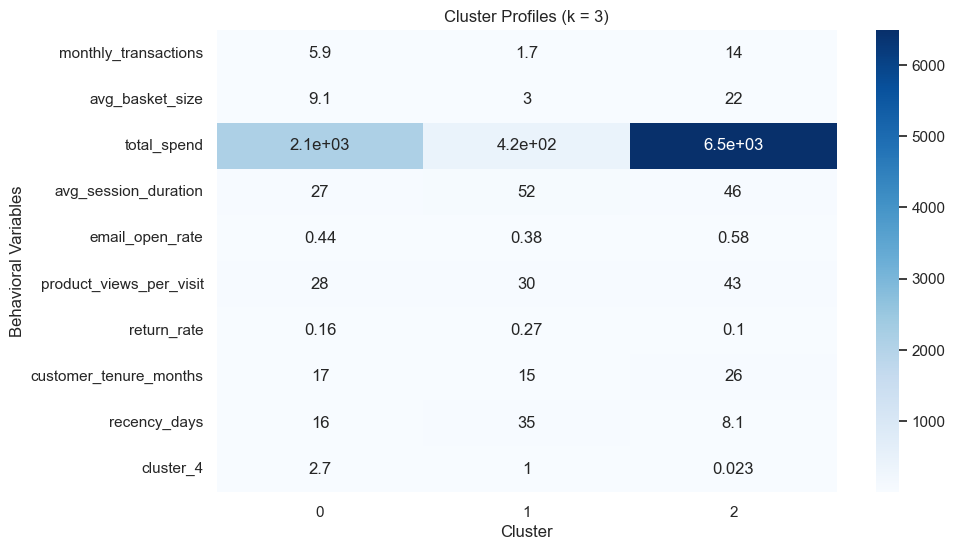

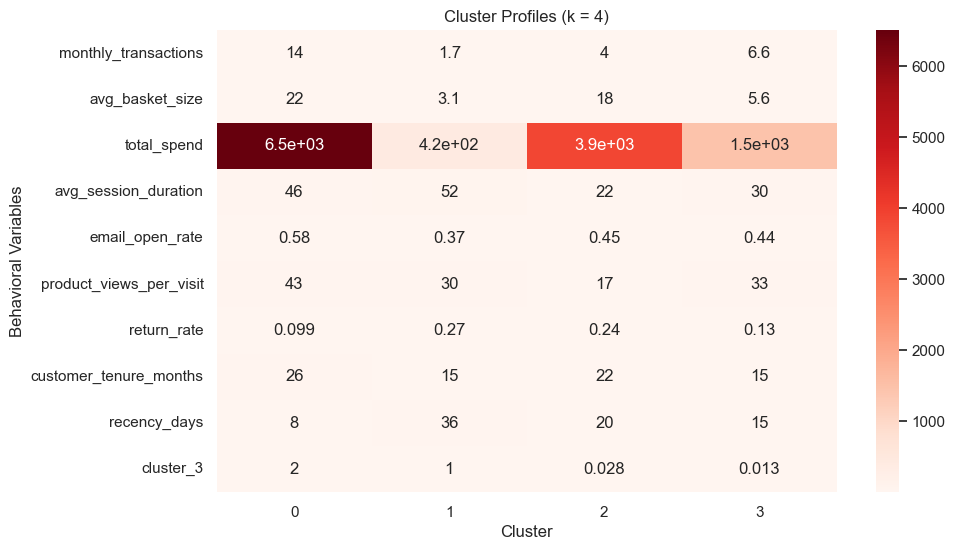

In [302]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_3.T, cmap='Blues', annot=True)
plt.title('Cluster Profiles (k = 3)')
plt.xlabel('Cluster')
plt.ylabel('Behavioral Variables')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_4.T, cmap='Reds', annot=True)
plt.title('Cluster Profiles (k = 4)')
plt.xlabel('Cluster')
plt.ylabel('Behavioral Variables')
plt.show()

### 9.4-Characterization

#### Clustering Results (k = 3)

##### **Cluster 0 (50.87%) – Average Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 5.9     |
| Average Basket Size        | 9.1     |
| Total Spend                | 2139    |
| Avg. Session Duration (min)| 27      |
| Email Open Rate            | 0.44    |
| Product Views per Visit    | 28      |
| Return Rate                | 0.16    |
| Customer Tenure (months)   | 17      |
| Recency (days)             | 16      |

 These are your average customers. They shop somewhat regularly with moderate spending and reasonable engagement. They show potential to be nurtured into higher value segments.



##### **Cluster 1 (31.47%) – Low Value  Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 1.7     |
| Average Basket Size        | 3.0     |
| Total Spend                | 420     |
| Avg. Session Duration (min)| 52      |
| Email Open Rate            | 0.38    |
| Product Views per Visit    | 30      |
| Return Rate                | 0.27    |
| Customer Tenure (months)   | 15      |
| Recency (days)             | 35      |

These customers shop infrequently, spend very little, and return products often. Despite spending time browsing, their low conversion suggests friction in the buying process.



##### **Cluster 2 (17.67%) – High Value Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 14.0    |
| Average Basket Size        | 22.0    |
| Total Spend                | 6489    |
| Avg. Session Duration (min)| 46      |
| Email Open Rate            | 0.58    |
| Product Views per Visit    | 43      |
| Return Rate                | 0.10    |
| Customer Tenure (months)   | 26      |
| Recency (days)             | 8.1     |

These are your most valuable and loyal customers. They buy often, spend a lot, engage with emails, and rarely return items. They are ideal for loyalty programs and personalized offers.

---

#### Clustering Results (k = 4)

##### **Cluster 0 (17.50%) – High Value Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 14.0    |
| Average Basket Size        | 22.0    |
| Total Spend                | 6507    |
| Avg. Session Duration (min)| 46      |
| Email Open Rate            | 0.58    |
| Product Views per Visit    | 43      |
| Return Rate                | 0.099   |
| Customer Tenure (months)   | 26      |
| Recency (days)             | 8.0     |

These customers are highly valuable. They purchase frequently, spend a lot, and are engaged and loyal. Focus on retention and exclusive experiences.



##### **Cluster 1 (30.97%) – Low Value Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 1.7     |
| Average Basket Size        | 3.1     |
| Total Spend                | 420     |
| Avg. Session Duration (min)| 52      |
| Email Open Rate            | 0.37    |
| Product Views per Visit    | 30      |
| Return Rate                | 0.27    |
| Customer Tenure (months)   | 15      |
| Recency (days)             | 36      |

These users are not very active. They may browse often but rarely convert, and return frequently. Likely need reactivation campaigns or deeper customer research.



##### **Cluster 2 (14.43%) – Average Potential Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 4.0     |
| Average Basket Size        | 18.2    |
| Total Spend                | 3876    |
| Avg. Session Duration (min)| 22      |
| Email Open Rate            | 0.45    |
| Product Views per Visit    | 17      |
| Return Rate                | 0.24    |
| Customer Tenure (months)   | 22      |
| Recency (days)             | 20      |

These customers have decent value and could be nurtured into becoming loyal clients. Their potential can be unlocked with targeted promotions and engagement.



##### **Cluster 3 (37.10%) – Average  Low Spend Customers**
| Metric                     | Value   |
|----------------------------|---------|
| Monthly Transactions       | 6.6     |
| Average Basket Size        | 5.6     |
| Total Spend                | 1450    |
| Avg. Session Duration (min)| 30      |
| Email Open Rate            | 0.44    |
| Product Views per Visit    | 33      |
| Return Rate                | 0.13    |
| Customer Tenure (months)   | 15      |
| Recency (days)             | 15      |

 These are consistent shoppers with modest spending habits. They interact regularly with the brand and could be receptive to targeted promotions or personalized product recommendations.

## Section 10: Cluster Validation - Silhouette Analysis

### 10.1-Silhouette Plot

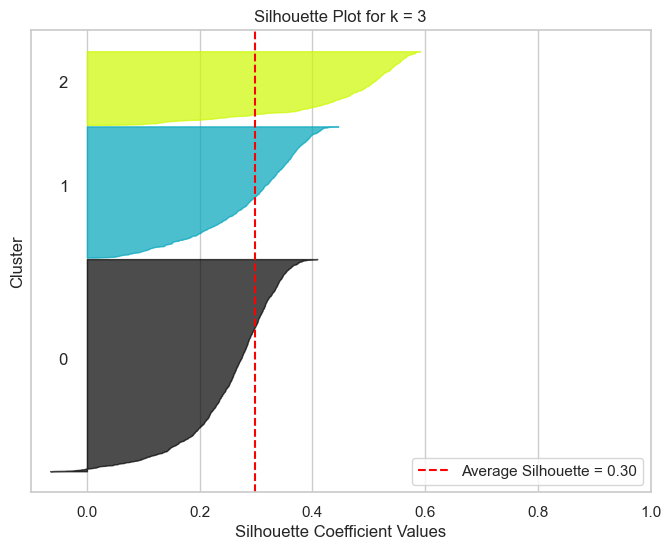

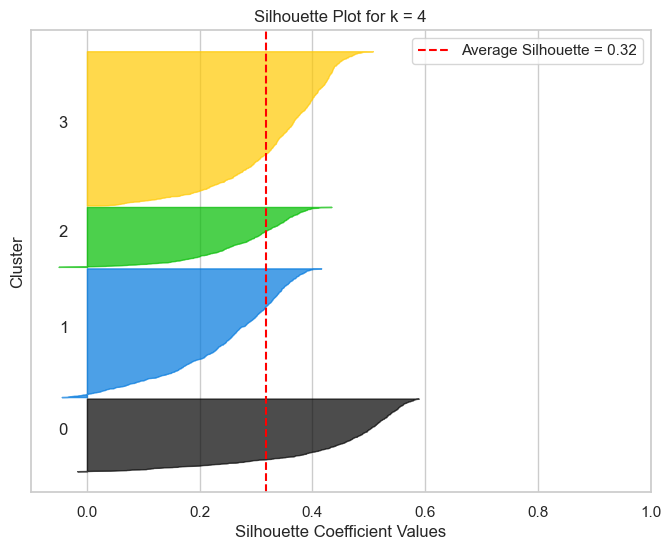

In [303]:

def plot_silhouette(X, labels, k):
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax.set_title(f"Silhouette Plot for k = {k}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average Silhouette = {silhouette_avg:.2f}")
    ax.legend()
    ax.set_yticks([])  
    ax.set_xlim([-0.1, 1])
    plt.show()


plot_silhouette(df_scaled, kmeans_3.labels_, 3)


plot_silhouette(df_scaled, kmeans_4.labels_, 4)


### 10.2-Interpretation

For k = 3, the average silhouette score is 0.30, indicating a moderately structured clustering solution. Cluster 2 appears to be the most well defined, as its silhouette values are consistently high, suggesting that customers in this group are well matched . Cluster 1 is fairly well defined too, but with slightly more variation.Cluster 0 shows a wider range of silhouette scores, including many values close to 0, indicating weaker separation.

For k = 4, the average silhouette score improves slightly to 0.32. Cluster 0 and Cluster 3 are the most distinct, with most customers having high silhouette values. However, Cluster 2 shows some silhouette values near or below zero, indicating potential overlap or poor cluster assignment. Cluster 1 also displays moderate silhouette values, suggesting less clear boundaries.

Even though the silhouette score is slightly better for k = 4 (0.32) compared to k = 3 (0.30), using k = 3 makes it easier to understand and work with the clusters. With three groups, we can clearly think of them as high value, low value, and average customers, which is useful for making business decisions. The four cluster version adds more detail, but it also makes things more complicated without a big improvement in separation.Thus, the choice between k = 3 and k = 4 depends on whether simplicity or finer differentiation is prioritized.

## Section 11: Cluster Visualization (PCA Projection)

### 11.1-Apply PCA

In [304]:

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])


### 11.2-Scatter Plot

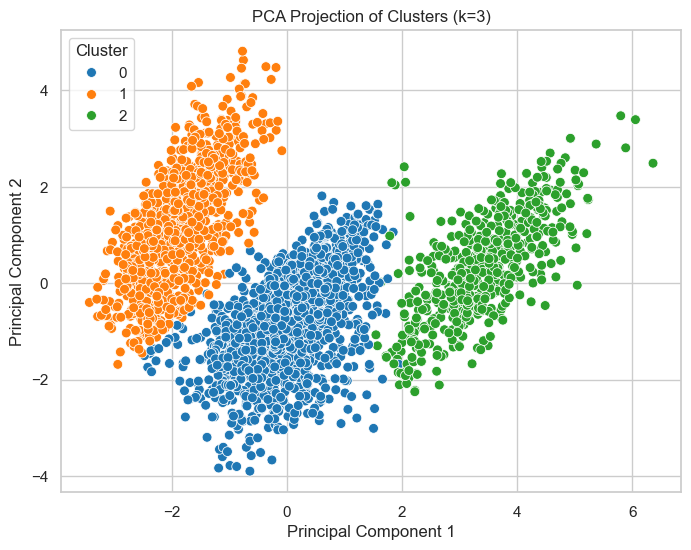

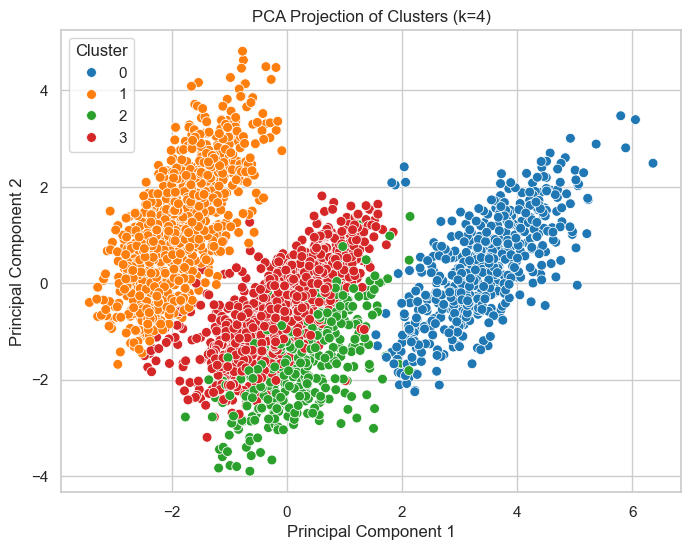

In [305]:
pca_df['cluster'] = df_numeric['cluster_3']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=50)
plt.title('PCA Projection of Clusters (k=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

pca_df['cluster'] = df_numeric['cluster_4']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=50)
plt.title('PCA Projection of Clusters (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### 11.3-Add Centroids

/Users/paud/anaconda3/envs/IDM4SEM/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


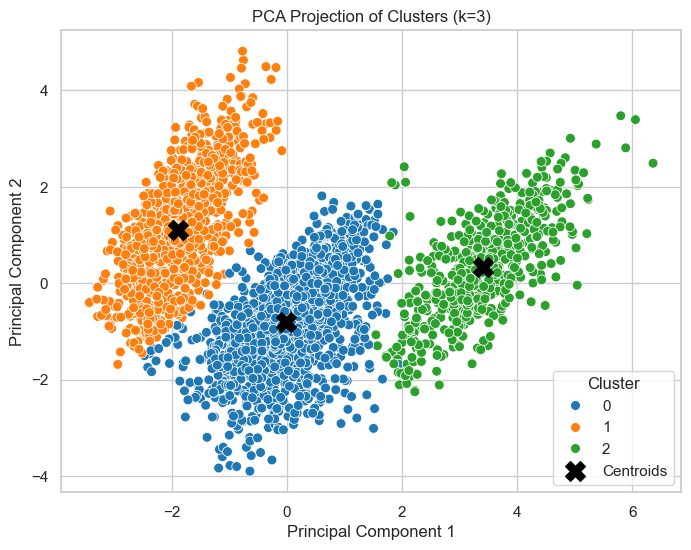

/Users/paud/anaconda3/envs/IDM4SEM/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


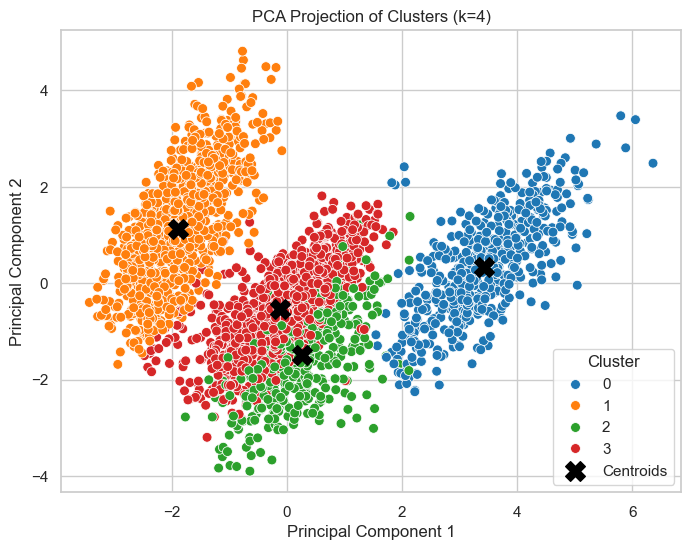

In [308]:
pca_df['cluster'] = df_numeric['cluster_3']
centroids_3 = pca.transform(kmeans_3.cluster_centers_)  
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=50)
plt.scatter(centroids_3[:, 0], centroids_3[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title('PCA Projection of Clusters (k=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


pca_df['cluster'] = df_numeric['cluster_4']
centroids_4 = pca.transform(kmeans_4.cluster_centers_)  
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=50)
plt.scatter(centroids_4[:, 0], centroids_4[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title('PCA Projection of Clusters (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()






### 11.4-Variance Explained

In [309]:
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1 y PC2: {explained_variance[0]:.2f}, {explained_variance[1]:.2f}")
print(f"Varianza total explicada: {explained_variance.sum():.2f}")


Varianza explicada por PC1 y PC2: 0.41, 0.21
Varianza total explicada: 0.62


### 11.5-Note Limitation

This 2D plot is just a simplified view. The real clusters exist in 9 dimensions, so what we see here is only a projection. Some details may be lost or look different from the full space.

## Section 12: Technical Conclusion

The analysis determined that the optimal number of clusters was four, justified by the elbow method and the Silhouette score, which reached a maximum value close to 0.52, indicating a reasonable cluster structure. When comparing methods, K-means showed better performance than the hierarchical method, given its higher Silhouette score and better separation between groups. The identified segments presented distinct characteristics: one group with high spending and loyalty, another with low digital interaction, one with erratic behavior, and one with high product return. This segmentation provides a solid foundation for personalizing marketing and loyalty strategies.